In [1]:
"""
SCT Table Classifier - Training
Trains a VLM-based classifier to identify Summary Compensation Tables.
"""
import json, random
from pathlib import Path
from tqdm.auto import tqdm
from datasets import load_dataset
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoModelForVision2Seq, AutoProcessor
from PIL import Image as PILImage

# Evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Save model
from safetensors.torch import load_file, save_file

# Config
SEED = 42424242
BASE_PATH = Path("/home/pdipasquale/MIIA/stuff")
HF_DATASET = "pierjoe/sec-table-classifier"

random.seed(SEED)
torch.manual_seed(SEED)

/home/pdipasquale/MIIA/stuff/.stuff/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load dataset from HuggingFace
dataset_split = load_dataset(HF_DATASET)
print(f"Train: {len(dataset_split['train'])} | Test: {len(dataset_split['test'])}")

Train: 3639 | Test: 910


# Training

In [3]:
MODEL_NAME = "Qwen/Qwen3-VL-4B-Instruct"
BATCH_SIZE = 2
EPOCHS = 3
LR = 1e-5
DEVICE = "cuda"


MODEL_SAVE_NAME = "exp2-weighted-loss-qwen3"

MODEL_PATH = BASE_PATH / "hf" / "models" / MODEL_SAVE_NAME
HEAD_PATH = MODEL_PATH / "head"
FULL_PATH = MODEL_PATH / "full"
HEAD_PATH.mkdir(parents=True, exist_ok=True)
FULL_PATH.mkdir(parents=True, exist_ok=True)

In [4]:
# Load base model and processor
processor = AutoProcessor.from_pretrained(MODEL_NAME)
base_model = AutoModelForVision2Seq.from_pretrained(
    MODEL_NAME, 
    torch_dtype=torch.bfloat16,
    device_map="cuda:0"
)
print(f"Model loaded: {MODEL_NAME}")

/home/pdipasquale/MIIA/stuff/.stuff/lib/python3.12/site-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


Model loaded: Qwen/Qwen3-VL-4B-Instruct


## model architetcture

In [5]:
# Classifier model with classification head on top of VLM
class VLMClassifier(nn.Module):
    def __init__(self, base_model, hidden_size=None, num_labels=2):
        super().__init__()
        self.base_model = base_model
        # Get hidden size from config (Qwen3-VL uses text_config.hidden_size)
        if hidden_size is None:
            if hasattr(base_model.config, 'text_config'):
                hidden_size = base_model.config.text_config.hidden_size
            else:
                hidden_size = base_model.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_labels)
        )
        # self.loss_fn = nn.CrossEntropyLoss()
        self.loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0]).to(DEVICE))
        
    def forward(self, input_ids, attention_mask, pixel_values, image_grid_thw, labels=None):
        # Get model outputs (last hidden state)
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            image_grid_thw=image_grid_thw,
            output_hidden_states=True,
            return_dict=True
        )
        # Use last hidden state, take mean over sequence
        hidden_states = outputs.hidden_states[-1]  # (batch, seq, hidden)
        pooled = hidden_states.mean(dim=1)  # (batch, hidden)
        logits = self.classifier(pooled.float())  # (batch, num_labels)
        
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        
        return {"loss": loss, "logits": logits}

# Freeze base model, only train classifier head
for param in base_model.parameters():
    param.requires_grad = False

model = VLMClassifier(base_model, num_labels=2).to(DEVICE)
print(f"Trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Trainable params: 1,312,258


## training loop

In [6]:
# Custom collate function for VLM
def collate_fn(batch):
    images = []
    labels = []
    
    for item in batch:
        img = item["image"]
        if isinstance(img, dict) and "path" in img:
            img = PILImage.open(img["path"]).convert("RGB")
        images.append(img)
        labels.append(item["label"])
    
    # Create simple prompt for classification
    messages_batch = []
    for img in images:
        messages_batch.append([{
            "role": "user",
            "content": [
                {"type": "image", "image": img},
                {"type": "text", "text": "Classify this table."}
            ]
        }])
    
    # Process with Qwen processor
    texts = [processor.apply_chat_template(m, tokenize=False, add_generation_prompt=True) for m in messages_batch]
    inputs = processor(
        text=texts,
        images=images,
        padding=True,
        return_tensors="pt"
    )
    
    inputs["labels"] = torch.tensor(labels)
    return inputs

# Create dataloaders
train_loader = DataLoader(dataset_split["train"], batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(dataset_split["test"], batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
print(f"Train batches: {len(train_loader)} | Test batches: {len(test_loader)}")

Train batches: 1820 | Test batches: 455


In [7]:
# Training loop
optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=LR/2)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for batch in pbar:
        # Move to device
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        pixel_values = batch["pixel_values"].to(DEVICE, dtype=torch.bfloat16)
        image_grid_thw = batch["image_grid_thw"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, pixel_values, image_grid_thw, labels)
        loss = outputs["loss"]
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = outputs["logits"].argmax(dim=-1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{correct/total:.2%}")
    
    print(f"Epoch {epoch+1} - Loss: {total_loss/len(train_loader):.4f} | Acc: {correct/total:.2%}")

Epoch 1/3: 100%|██████████| 1820/1820 [03:34<00:00,  8.49it/s, acc=90.82%, loss=0.0186]


Epoch 1 - Loss: 0.2520 | Acc: 90.82%


Epoch 2/3: 100%|██████████| 1820/1820 [03:31<00:00,  8.61it/s, acc=97.61%, loss=0.1730]


Epoch 2 - Loss: 0.0923 | Acc: 97.61%


Epoch 3/3: 100%|██████████| 1820/1820 [03:28<00:00,  8.74it/s, acc=98.52%, loss=0.0001]

Epoch 3 - Loss: 0.0619 | Acc: 98.52%


## Eval & Save

In [8]:
# scommenta se bisogna caricare il modello 
# # Load base model
# base_model = AutoModelForVision2Seq.from_pretrained(MODEL_NAME, torch_dtype=torch.bfloat16, device_map="cuda:0")
# processor = AutoProcessor.from_pretrained(MODEL_NAME)

# # Create classifier and load weights
# model = VLMClassifier(base_model, num_labels=2).to(DEVICE)
# model.classifier.load_state_dict(load_file(BASE_PATH / "hf" /"models" / MODEL_SAVE_NAME / "head" / "classifier_head.safetensors"))
# model.eval()
# print("✓ Model loaded")

Evaluating:   0%|          | 0/455 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 455/455 [00:52<00:00,  8.66it/s]


Test Accuracy: 99.34%


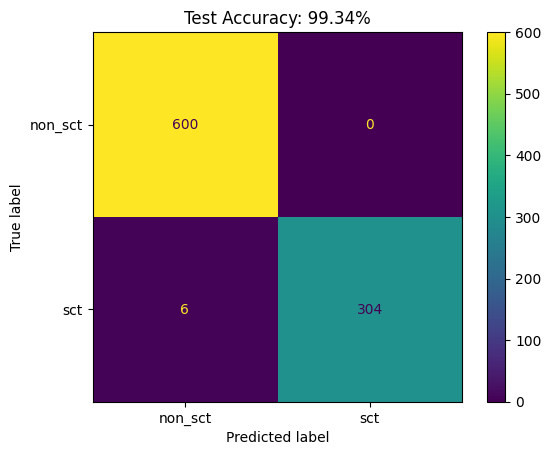

In [9]:
# Evaluation
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        pixel_values = batch["pixel_values"].to(DEVICE, dtype=torch.bfloat16)
        image_grid_thw = batch["image_grid_thw"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)
        
        outputs = model(input_ids, attention_mask, pixel_values, image_grid_thw)
        preds = outputs["logits"].argmax(dim=-1)
        
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

print(f"\nTest Accuracy: {correct/total:.2%}")
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["non_sct", "sct"])
disp.plot()
plt.title(f"Test Accuracy: {correct/total:.2%}")
plt.show()


In [10]:
# 1. Save classifier head only (for lightweight loading)
torch.save(model.classifier.state_dict(), HEAD_PATH / "classifier_head.pt")
save_file(model.classifier.state_dict(), HEAD_PATH / "classifier_head.safetensors")
print(f"✓ Head saved to: {HEAD_PATH}")

# 2. Save FULL model (base + classifier head)
# Save base model
base_model.save_pretrained(FULL_PATH)
processor.save_pretrained(FULL_PATH)

# Save classifier head separately
save_file(model.classifier.state_dict(), FULL_PATH / "classifier_head.safetensors")

# Save classifier config (get hidden_size from text_config for Qwen3-VL)
hidden_size = base_model.config.text_config.hidden_size if hasattr(base_model.config, 'text_config') else base_model.config.hidden_size
classifier_config = {
    "base_model": MODEL_NAME,
    "hidden_size": hidden_size,
    "num_labels": 2,
    "label_names": ["non_sct", "sct"]
}
with open(FULL_PATH / "classifier_config.json", "w") as f:
    json.dump(classifier_config, f, indent=2)

print(f"✓ Full model saved to: {FULL_PATH}")

# 3. Push to HuggingFace Hub
from huggingface_hub import HfApi, upload_folder

HF_MODEL_REPO = "pierjoe/Qwen3-VL-4B-SCT-Classifier"

api = HfApi()
api.create_repo(repo_id=HF_MODEL_REPO, exist_ok=True)

upload_folder(
    folder_path=str(FULL_PATH),
    repo_id=HF_MODEL_REPO,
    repo_type="model"
)
print(f"✓ Pushed to: https://huggingface.co/{HF_MODEL_REPO}")

✓ Head saved to: /home/pdipasquale/MIIA/stuff/hf/models/exp2-weighted-loss-qwen3/head
✓ Full model saved to: /home/pdipasquale/MIIA/stuff/hf/models/exp2-weighted-loss-qwen3/full


Processing Files (4 / 4): 100%|██████████| 8.89GB / 8.89GB,  602MB/s  
New Data Upload: 100%|██████████|  127MB /  127MB, 12.7MB/s  


✓ Pushed to: https://huggingface.co/pierjoe/Qwen3-VL-4B-SCT-Classifier


## FN/FP

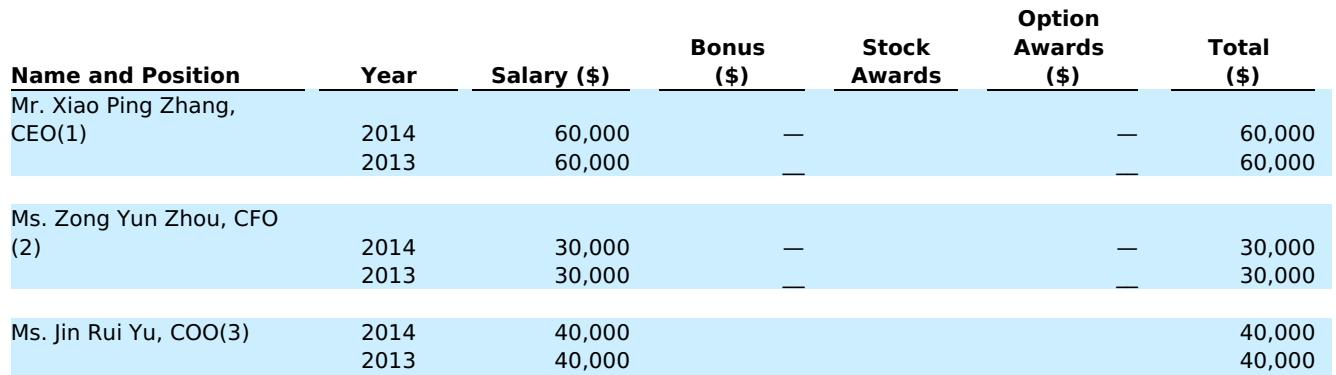

In [12]:
# Find misclassified samples
test_data = dataset_split["test"]

false_positives = []  # non_sct predicted as sct
false_negatives = []  # sct predicted as non_sct

for i, (pred, label) in enumerate(zip(all_preds, all_labels)):
    if pred != label:
        sample = test_data[i]
        if pred == 1 and label == 0:
            false_positives.append((i, sample))
        else:
            false_negatives.append((i, sample))
            
# sample = false_positives[1]
# display(sample[-1]["image"])
sample = false_negatives[0]
display(sample[-1]["image"])